# integrated gradients with pytorch

implementing integrated gradients using pytorch to explain model predictions.

first, import necessary libraries.

In [13]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

load a pre-trained googlenet model and set it to evaluation mode.

In [14]:
model = models.googlenet(pretrained=True)
model.eval();

define functions to preprocess images and decode predictions.

In [15]:
def get_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content))

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def predict(img_tensor, model):
    with torch.no_grad():
        output = model(img_tensor.unsqueeze(0))
        return F.softmax(output, dim=1)

download and prepare the example image.

In [16]:
img_url = "http://storage.googleapis.com/download.tensorflow.org/example_images/San_Francisco_fireboat_showing_off.jpg"
img = get_image(img_url)
img_input = preprocess(img).unsqueeze(0)
img_input.requires_grad = True

implement the integrated gradients algorithm. it interpolates between a baseline and the input, computes gradients, and approximates the integral.

In [17]:
def integrated_gradients(inputs, model, target_label_idx, baseline=None, steps=50):
    if baseline is None:
        baseline = torch.zeros_like(inputs)

    # generate interpolated inputs
    alphas = torch.linspace(0, 1, steps+1).to(inputs.device)
    alphas_x = alphas.view(-1, 1, 1, 1)
    interpolated_inputs = baseline + alphas_x * (inputs - baseline)
    interpolated_inputs = interpolated_inputs.clone().detach().requires_grad_(True)

    # compute gradients
    outputs = model(interpolated_inputs)
    score = outputs[:, target_label_idx].sum()
    score.backward()
    grads = interpolated_inputs.grad
    
    # approximate integral using trapezoidal rule
    avg_grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = avg_grads.mean(dim=0)

    # compute integrated gradients
    delta = inputs - baseline
    ig = delta * avg_grads
    return ig

calculate attributions for the top predicted class.

In [18]:
output = model(img_input)
target_idx = output.argmax().item()

attributions = integrated_gradients(img_input, model, target_idx)

visualize the original image and the attribution mask.

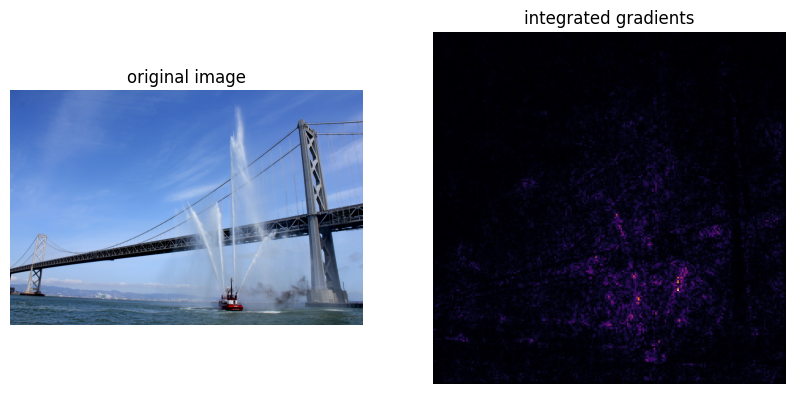

In [19]:
def visualize(attributions, original_img):
    attr = attributions[0].detach().numpy()
    attr = np.transpose(attr, (1, 2, 0))
    attr = np.sum(np.abs(attr), axis=2)
    
    # normalize
    attr = (attr - attr.min()) / (attr.max() - attr.min())

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(original_img)
    ax[0].axis('off')
    ax[0].set_title('original image')

    ax[1].imshow(attr, cmap='inferno')
    ax[1].axis('off')
    ax[1].set_title('integrated gradients')
    plt.show()

visualize(attributions, img)